In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from code.plot_utils import plot_pretty
plot_pretty()
from colossus.cosmology import cosmology

def compute_lf_bootstrap (lum, vmi, lbins, nbootstraps = 20):
    """
    computes LF and bootstrap errors given a vector of luminosities
    lum, 1/Vmax values (vmi), and specified luminosity bins (lbins)
    """
    l_dist = np.zeros((nbootstraps, len(lbins) - 1))

    for i in range(nbootstraps):
        ind = np.random.randint(0, len(lum), len(lum))
        l_dist[i], ldbins = np.histogram(lum[ind], weights=vmi[ind], bins=lbins)

    return (l_dist.mean(0), l_dist.std(0, ddof=1))


In [2]:
import numpy as np
from matplotlib import pyplot as plt
import math
from scipy.interpolate import UnivariateSpline
import matplotlib.cm as cm
import matplotlib.colors as colors

import numpy as np
import code.galaxy_model as gm
from colossus.cosmology import cosmology

# define a vector of cosmological parameters:    
my_cosmo = {'flat': True, 'H0': 70.0, 'Om0': 0.27, 'Ob0': 0.045714, 'sigma8': 0.82, 'ns': 0.96}
# set my_cosmo to be the current cosmology
cosmo = cosmology.setCosmology('my_cosmo', my_cosmo)  
def nmstz(ms, z):
    """
    compute analytic double Schechter representation of the observed stellar mass function as a function
    of redshift using calibration of Leja et al. 2015, 798, 115 (see eqs in their S 2)
    note that this calibration is for 3<z<0 - I checked it gives grossly incorrect results at z>3
    
    input: ms - array of stellar masses
            z - redshift
    output: dn/dlog10(M*) in dex^-1 Mpc^-3
    """
    if z <= 3.0:
        z2 = z * z; lms = np.log10(ms)
        lphi1 = -2.46 + 0.07*z - 0.28*z2 
        lphi2 = -3.11 - 0.18*z - 0.03*z2
        lmst  = 10.72 - 0.13*z + 0.11*z2
        mst = np.power(10.,lmst); mus = ms/mst
        a1 = -0.39; a2 = -1.53
        nmstz = np.log(10.)*np.exp(-mus)*(mus)*(10.**lphi1*mus**a1+10.**lphi2*mus**a2)
    else:
        """
        high-z SMF estimates from CANDELS and S-CANDELS from the talk by Song 
        http://www.astrodeep.eu/wp-content/uploads/2015/02/MSong.sesto_.Jan2015.pdf
        """
        z_h     = [4.0, 5.0, 6.0, 7.0]
        lmst_z  = [10.68, 10.58, 10.22, 10.45]
        ah_z    = [-1.59, -1.68, -1.89, -1.93]
        lphi_z = [-3.77, -3.99, -4.34, -4.94]

        lmst  = UnivariateSpline(z_h, lmst_z)
        ahz   = UnivariateSpline(z_h, ah_z)
        lphiz = UnivariateSpline(z_h, lphi_z)
        a = ahz(z); mst = np.power(10., lmst(z)); phiz = np.power(10.,lphiz(z))
        mus = ms/mst
        nmstz = np.log(10.)*phiz*np.exp(-mus)*(mus)**(a + 1.0)

    return nmstz


lms = np.arange(6., 12.6, 0.01)
ms = np.power(10., lms)

philejaz0 = nmstz(ms,0.0)
def fsub(mh, z):
    """
    subhalo fraction calibration from the Appendix G of Behroozi et al. 2013
    as a function of Mpeak - eqs G9-10
    input: mh = halo mass in Msun
           z  = redshift
    """
    aexp = 1.0/(1.0+z)
    aexp2 = aexp*aexp; aexp3 = aexp2*aexp; aexp4 = aexp3*aexp
    Ca = -1.91 + 6.23*aexp - 15.07*aexp2 + 15.02*aexp3  - 5.29*aexp4
    Mcutoff = 10.66 + 15.93*aexp - 21.39*aexp2 + 18.20*aexp3 - 8.21*aexp4
    return 10.**Ca*np.log10(10.**Mcutoff/mh)

In [3]:
from code.setup import data_home_dir
from scipy.interpolate import UnivariateSpline

msc, nmsc = np.loadtxt(data_home_dir()+'smf_sdss_gama_composite.dat', usecols=(0,1), unpack=True)
nmsc = nmsc[msc>1.e7]; msc = msc[msc>1.e7]
# note that these Ms are in h^-2 Msun, nmsc is in h^3/dex/Mpc^3
nmscsp = UnivariateSpline(np.log10(msc/cosmo.h**2), np.log10(nmsc*cosmo.h**3), s=0.0)

def nms_compositez0(ms):
    """
    composite stellar mass function using results from the GAMA survey 
    and Meert et al. 2015 catalog for the SDSS survey with updated PyMorph photometry
    input: ms - vector of stellar masses in Msun
    oputput: dn/dlog10(M*) in dex^-1 Mpc^-3
    """
    return 10.**nmscsp(np.log10(ms))

def nms_compositez0_fit(ms):
    """
    composite stellar mass function using Baldry et al. 2012 from GAMA survey 
    and Bernardi et al. 2013 for the SDSS survey with updated PyMorph photometry
    input: ms - vector of stellar masses in Msun
    oputput: dn/dlog10(M*) in dex^-1 Mpc^-3
    """
    #
    # Baldry et al. 2012 stellar mass function for small M*
    #
    lmstar = 10.66
    phi1s = 3.96e-3; alpha1=-0.35; phi2s = 6.9e-4; alpha2=-1.57;

    mstar = 10.**lmstar; mus =  ms/mstar
    dnms1 = np.exp(-mus)*(phi1s*mus**alpha1 + phi2s*mus**alpha2)/mstar

    #
    # using Bernardi et al. 2013 double Schechter fit for large M*
    #

    mstarb = 0.0094e9; phisb = 1.040e-2; alphab = 1.665; betab = 0.255
    phisg = 0.675e-2; mstarg = 2.7031e9; gammag = 0.296

    gammanorm = math.gamma(alphab/betab)

    musb = ms/mstarb; musg = ms/mstarg
    dnms2 = (phisb*np.exp(-musb**betab)*musb**(alphab-1)/(mstarb)*betab/gammanorm +
             phisg*musg**(gammag-1)*np.exp(-musg)/mstarg)

    #
    # multiply by M* and ln(1) to get dn/dlog10M and take maximum 
    # of Baldry et al. and Bernardi et al stellar mass functions to construct the composite
    #
    dnms1 = dnms1*ms; dnms2 = dnms2*ms
    dnms = np.maximum(dnms1,dnms2)*np.log(10.)
    return dnms

def lf_schechter(L, phis, Lstar, alpha):
    mus = np.power(10,L)/np.power(10,Lstar)
    #print "phis, Lstar, alpha", phis, Lstar, alpha
    return np.log(10.)*phis*mus**(alpha)*np.exp(-mus)

def phiMHI(mHI):
    # Schechter fit from Martin et al. 2010  
    # which approximates the actual ALFALFA measurement - see HW2
    phis = 4.8e-3; alpha = -0.33; Mstar = 9.96
    return lf_schechter(np.log10(mHI), phis, Mstar, alpha)/cosmo.h**3

lms = np.arange(6., 12.6, 0.01)
ms = np.power(10., lms)

phiz0 = nms_compositez0(ms)
phiz0f = nms_compositez0_fit(ms)

philejaz0 = nmstz(ms,0.0)
phiHI = phiMHI(ms)
fbaru = cosmo.Ob0/cosmo.Om0
#

z = np.array([0.0, 0.5, 1.0, 2.0, 3.0, 5.0, 7.0])
lmh = np.arange(6.,15.5,0.05)
mh = np.power(10.,lmh)
# compute Lagrangian radius corresponding to perturbation of mass mh in /h Mpc
rh = cosmo.lagrangianR(mh)
z0 = 0.0
# compute rms fluctuation sigma(R) using default Eisenstein & Hu 1998 power spectrum and tophat filter
sig = cosmo.sigma(rh,z0)
# and its logarithmic derivative dlog(sigma)/dlogR
dsdr = cosmo.sigma(rh, z0, derivative='True')
# dln(sigma)/dlnR -> dln(sigma)/dlnM, M = (4*pi/3) rho_mean * R^3
dsdm = dsdr / 3.0
q_smt = 0.3; A_smt = 0.322; a_smt = 0.707



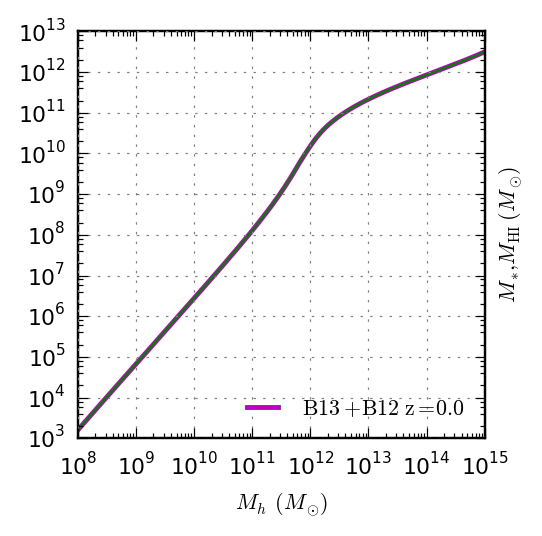

In [4]:

fbaru = cosmo.Ob0/cosmo.Om0
z=0.0
mhd = mh/cosmo.h
nu = cosmo.peakHeight(mh, z)
nup = np.sqrt(a_smt)*nu
dsdmz = dsdm*cosmo.growthFactor(z)
nsmt2 = A_smt*np.sqrt(2.0/np.pi)*cosmo.Om0*2.77e11/mh*(1.0+1./nup**(2.*q_smt))*nup*np.abs(dsdm)*np.exp(-0.5*nup**2)

# construct spline of dn/dM as a function of M for cumulative mass function
mfhsp  = UnivariateSpline(np.log(mhd), nsmt2, s=0.0)
mfssp  = UnivariateSpline(ms, phiz0f/np.log(10.)/ms, s=0.0)
mfssp2 = UnivariateSpline(ms, philejaz0/np.log(10.)/ms, s=0.0)
mfh1sp = UnivariateSpline(ms, phiHI/np.log(10.)/ms, s=0.0)
 
nmhi = np.zeros_like(mhd)
for i, md in enumerate(mhd):
    nmhi[i] = mfhsp.integral(np.log(md), np.log(mhd[-1]))
nmhi[-1] = 1.e-100

# add contribution of subhalos
nmhi = nmhi * (1.0+fsub(mhd,z))
#print fsub(mh/cosmo.h,z)
nmsi  = np.zeros_like(ms)
nmsi2 = np.zeros_like(ms)
nmh1i = np.zeros_like(ms)
for i, md in enumerate(ms):
    nmsi[i] = mfssp.integral(md, ms[-1])
    nmsi2[i] = mfssp2.integral(md, ms[-1])
    nmh1i[i] = mfh1sp.integral(md, ms[-1])
nmsi[-1] = 1.e-100
nmsi2[-1] = 1.e-100
nmh1i[-1] = 1.e-100

# halo mass function
fig,ax = plt.subplots(1,figsize=(3,3))

# reverse arrays for proper monotonicity for splines
msd = ms[::-1]
nmsid = nmsi[::-1]; nmsid2 = nmsi2[::-1]; nmh1id = nmh1i[::-1]
nmsms  = UnivariateSpline(np.log10(nmsid), np.log10(msd), s=0.0)
nmsms2 = UnivariateSpline(np.log10(nmsid2), np.log10(msd), s=0.0)

nmsmh1  = UnivariateSpline(np.log10(np.maximum(1.e-100,nmh1id)), np.log10(msd), s=0.0)

mhms  = nmsms(np.log10(nmhi)); 
mhms2 = nmsms2(np.log10(nmhi))
mhmh1 = nmsmh1(np.log10(nmhi))
plt.rc("savefig",dpi=175)
plt.rc('text', usetex=False)
plt.rc('font',size=9)
plt.rc('xtick.major',pad=5); plt.rc('xtick.minor',pad=5)
plt.rc('ytick.major',pad=5); plt.rc('ytick.minor',pad=5)
# Mh-M* relation
ax.set_xlabel(r'$M_h\ (M_{\odot})$'); ax.set_ylabel(r'$M_*, M_{\rm HI}\ (M_{\odot})$')
ax.set_xlim(1.e8, 1.e15); ax.set_ylim(1.e3,1.e13)
ax.set_xscale('log'); ax.set_yscale('log')
ax.yaxis.set_label_position('right')

ax.plot(mh/cosmo.h,10.**mhms/cosmo.h**2,c='m',linewidth=2.0, label=r'$\rm B13+B12\ z=%.1f$'%z)

#ax.plot(mh/cosmo.h,10.**mhms2/cosmo.h**2,c='r',linewidth=2.0, label=r'$\rm Leja\ et\ al. 15\ z=%.1f$'%z)
#ax.plot(mh/cosmo.h,10.**mhmh1,c='slateblue',linewidth=2.0, label=r'$\rm HI, ALFALFA\ z=%.1f$'%z)
mhms_spline = UnivariateSpline(10.**mhms/cosmo.h**2, mh/cosmo.h, k=1)
ax.plot(mhms_spline(10.**mhms/cosmo.h**2), 10.**mhms/cosmo.h**2)
ax.legend(frameon=False, loc='lower right', fontsize=9)
ax.grid(c='gray')
plt.show()

(0.1, 100.0)

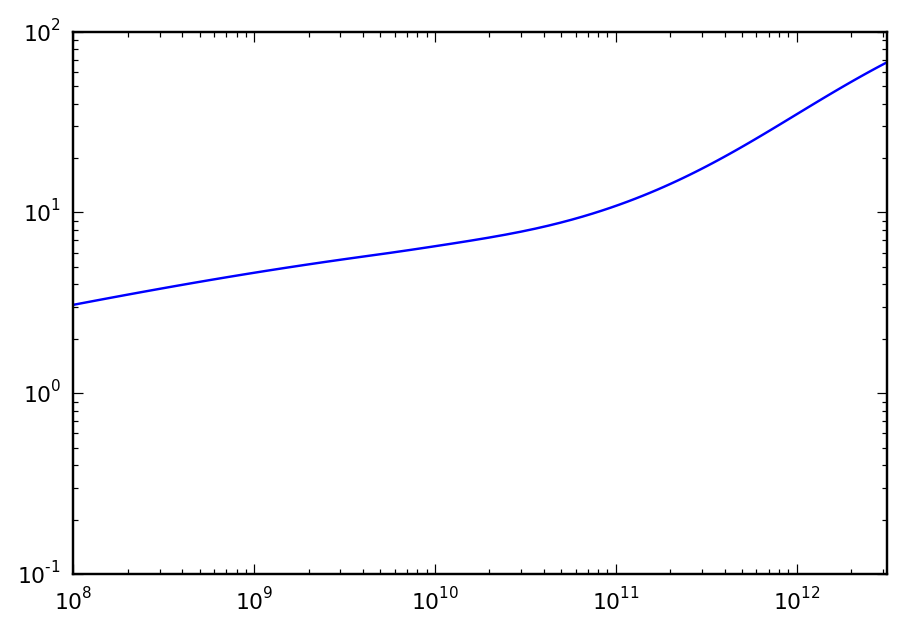

In [5]:
from colossus.cosmology import cosmology
from colossus.halo.mass_so import M_to_R
from colossus.halo.concentration import concentration

from colossus.halo.mass_defs import changeMassDefinition

# define a vector of cosmological parameters:    
my_cosmo = {'flat': True, 'H0': 70.0, 'Om0': 0.27, 'Ob0': 0.045714, 'sigma8': 0.82, 'ns': 0.96}
# set my_cosmo to be the current cosmology	
cosmo = cosmology.setCosmology('my_cosmo', my_cosmo)
z=0.0
Mh = mh/cosmo.h
M_star = 10.**mhms/cosmo.h**2
R200 = np.zeros((len(Mh)))
for i in range(len(R200)):
    cvir = concentration(Mh[i]+M_star[i], 'vir', z, model='diemer15')
    M200c, R200c, c200c = changeMassDefinition(Mh[i]+M_star[i], cvir, z, 'vir', '200c')
    R200[i] = M_to_R(M200c, 0.0, '200c')
eta = 0.045
r12 = eta*R200
plt.plot(M_star, r12)
plt.semilogy()
plt.semilogx()
plt.xlim([10**8.0, 10**12.5])
plt.ylim([10**-1., 10**2.])

The plot is not a perfect fit with the model but it comes quite close. It seems small values of $\eta$ fits, such as $0.01<\eta<0.02$ but the shape does not seem steep enough to match the results from homework 3. Here I just plotted this with the $\eta=0.045$ value found from the second part of the question. This implies that the observed size-stellar mass relation is influenced by angular momentum support, which stops the gas from falling completely into the centre of the potential well of the halo.

1 b)

[ 0.04544575  0.0454938   0.0455415   0.04558914  0.04563672  0.04568393
  0.0457313   0.04577807  0.04582511  0.04587144  0.04591803  0.04596394
  0.04600994  0.04605547  0.04610073  0.04614594  0.0461903   0.04623527
  0.04627855  0.04632343  0.04636544  0.04640982  0.04645096  0.04649387
  0.04653517  0.04657639  0.04661816  0.0466575   0.0466992   0.04673743
  0.04677705  0.04681648  0.04685386  0.0468936   0.04693008  0.04696746
  0.04700626  0.04704217  0.0470804   0.04711894  0.0471577   0.04719886
  0.04723813  0.04727957  0.04732116  0.04736278  0.04740646  0.04744865
  0.04749329  0.04753791  0.04758418  0.04763194  0.04768128  0.04773289
  0.04778672  0.04784338  0.04790275  0.0479657   0.04803162  0.04810145
  0.04817518  0.04825253  0.0483337   0.04841955  0.04850974  0.04860424
  0.04870319  0.04880661  0.04891453  0.04902697  0.04914389  0.04926518
  0.04939189  0.04952286  0.04965774  0.04979676  0.04994055  0.05008704
  0.0502379   0.05039087  0.05054714  0.05070391  0

(0.1, 100.0)

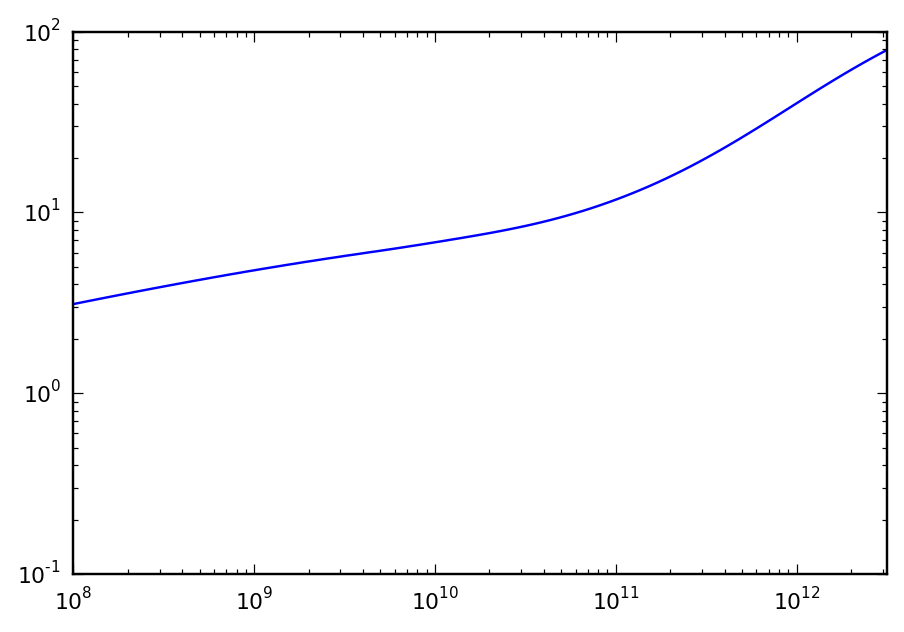

In [6]:
jm = 1
fR = 1
lmbda = 0.045
import numpy as np
from colossus.halo.concentration import concentration
from colossus.halo.mass_defs import changeMassDefinition
Mstar = 10.**np.linspace(8.,12.5,100)
mhalo = np.zeros((len(Mstar)))
for i in range(len(Mstar)):
    mhalo[i] = mhms_spline(Mstar[i])
z=0.
c = np.zeros((len(mhalo)))
fc = np.zeros((len(mhalo)))
M200c = np.zeros((len(mhalo)))
R200c = np.zeros((len(mhalo)))
c200c = np.zeros((len(mhalo)))
for i in range(len(mhalo)):
    c[i] = concentration(mhalo[i]+Mstar[i], 'vir', z, model='diemer15')
    # see eq. 23 in Mo, Mao & White 1998
    fc[i] = 0.5*c[i]*(1.-1./(1.+c[i])**2-2.*np.log(1.+c[i])/(1.+c[i]))/(c[i]/(1.+c[i])-np.log(1.+c[i]))**2
    M200c[i], R200c[i], c200c[i] = changeMassDefinition(mhalo[i]+Mstar[i], c[i], z, 'vir', '200c')
r12 = 1.187*jm*fc**(-0.5)*fR*lmbda*R200c
print 1.187*jm*fc**(-0.5)*fR*lmbda
plt.plot(Mstar, r12)
plt.semilogy()
plt.semilogx()
plt.xlim([10**8.0, 10**12.5])
plt.ylim([10**-1., 10**2.])

The plot looks quite similar to the plot made in a. (I've rescaled a to have the same $\eta$ values, roughly.) I've also printed out the values of the factor in front of $R_{200}$ and we can see it stays roughly constant over this mass range and stays very close to $\lambda$. 

Question #2

evolving halo of log10(Mh)=5.00 ...
evolving halo of log10(Mh)=5.15 ...
evolving halo of log10(Mh)=5.30 ...
evolving halo of log10(Mh)=5.45 ...
evolving halo of log10(Mh)=5.61 ...
evolving halo of log10(Mh)=5.76 ...
evolving halo of log10(Mh)=5.91 ...
evolving halo of log10(Mh)=6.06 ...
evolving halo of log10(Mh)=6.21 ...
evolving halo of log10(Mh)=6.36 ...
evolving halo of log10(Mh)=6.52 ...
evolving halo of log10(Mh)=6.67 ...
evolving halo of log10(Mh)=6.82 ...
evolving halo of log10(Mh)=6.97 ...
evolving halo of log10(Mh)=7.12 ...
evolving halo of log10(Mh)=7.27 ...
evolving halo of log10(Mh)=7.42 ...
evolving halo of log10(Mh)=7.58 ...
evolving halo of log10(Mh)=7.73 ...
evolving halo of log10(Mh)=7.88 ...


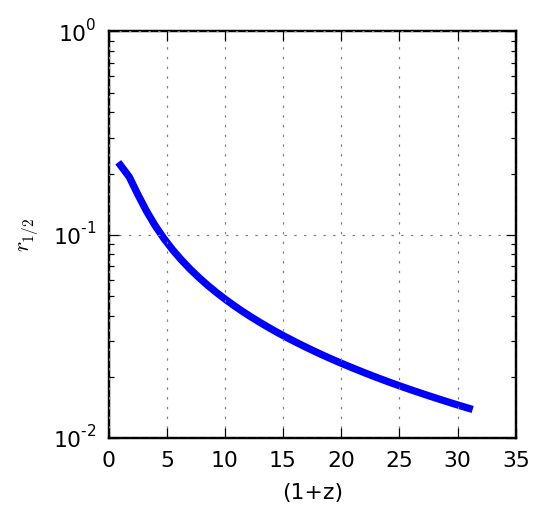

In [7]:
import numpy as np
import code.galaxy_model as gm
from colossus.cosmology import cosmology
from colossus.halo.concentration import concentration
from colossus.halo.mass_defs import changeMassDefinition

# define a vector of cosmological parameters:    
my_cosmo = {'flat': True, 'H0': 70.0, 'Om0': 0.27, 'Ob0': 0.045714, 'sigma8': 0.82, 'ns': 0.96}
# set my_cosmo to be the current cosmology
cosmo = cosmology.setCosmology('my_cosmo', my_cosmo)  
from scipy.integrate import odeint

# inherit class for this homework from the base model_galaxy class
# add the required functions to it
class gmodel_hw4(gm.model_galaxy):
    def __init__(self, *args, **kwargs):
        # only one model based on total gas density for starters, a better model is to be implemented
        super(gmodel_hw4, self).__init__(*args, **kwargs)
        return

    def Mhot(self, z):
        mnl = self.cosmo.nonLinearMass(z)
        mhot = 1.e12 * self.cosmo.h * np.maximum(2., 1.e12/(3.*mnl/self.cosmo.h))
        return mhot
       
    def UV_cutoff(self, z):
        """
        approximation to the cutoff mass in Fig 3 of Okamoto, Gao & Theuns 2008
        the output is mass in /h Msun. 
        """
        dummy = np.zeros_like(z)
        dummy[z>9] = 1.e6
        dummy[z<=9] = 6.e9*np.exp(-0.63*z[z<9]) # expression from Nick
        return  1.0/(1.0+(2.**(2./3.)-1.)*(dummy/self.Mh)**2)**(1.5)

    def Mg_in(self, t):
        dummy = self.fbuni*self.fg_in(t)*self.eps_in(t)*self.dMhdt(self.Mh,t)
        return dummy
    
    def fg_in(self,t):
        zd = self.cosmo.age(t, inverse=True)
        # here I implement soft suppression of baryon fraction, as seen in simulation (eq 2.2 in the notes)
        # results are qualitatively the same, but this function makes suppression a "softer" as a function of M
        return self.UV_cutoff(zd)
    
    def eps_in(self, t):
        zd = self.cosmo.age(t, inverse=True)
        epsin = 1.0
        if self.Mh >= self.Mhot(zd):
            epsin = 0.0
        return epsin
    def r12(self, t):
        jm = 1.
        fR = 1.
        lmbda = 0.045
        zd = self.cosmo.age(t, inverse=True)
        c = concentration(self.Mh, 'vir', zd, model='diemer15')
        fc = 0.5*c*(1.-1./(1.+c)**2-2.*np.log(1.+c)/(1.+c))/(c/(1.+c)-np.log(1.+c))**2
        M200c, R200c, c200c = changeMassDefinition(self.Mh*self.cosmo.h, c, zd, 'vir', '200c')
        return 1.187*jm*fR*lmbda*R200c/np.sqrt(fc)
    
    def Rd(self, r12):
        return r12/1.678

def test_galaxy_evolution(Minit, sfrmodel, cosmo, verbose):
    zg = np.linspace(20., 0., 40) # grid of redshifts
    t_output = cosmo.age(zg) # and corresponding times

    # instantiate a galaxy model at t=tinit assuming a given star fromation model and cosmology
    g = gmodel_hw4(t = t_output[0], Mh = Minit, Mg = None, Ms = None, MZ = None, 
                     sfrmodel = sfrmodel, cosmo = cosmo, verbose = verbose)
    
    # array of quantities to evolve with ODE solver
    y0 = np.array([g.Mh, g.Mg, g.Ms, g.MZ])
    # evolve y0 in time
    Mout = odeint(g.evolve, y0, t_output, rtol = 1.e-7, mxstep = 4000)
    
    # let's split the output into arrays with intuitive names
    Mhout = np.clip(Mout[:,0],0.0,1.e100)
    Mgout = np.clip(Mout[:,1],0.0,1.e100)
    Msout = np.clip(Mout[:,2],0.0,1.e100)
    MZout = np.clip(Mout[:,3],0.0,1.e100)

    return zg, t_output, Mhout, Mgout, Msout, MZout
sfrmodel = "gaslinear"  
# let's take a look at how a halo that has MW-like halo mass at z=0 evolves
# the class method test_galaxy_evolution does some basic run of the model and plots results, so let's setup 
# matplotlib parameters for plotting
from code.plot_utils import plot_pretty
%matplotlib inline
from matplotlib import pylab as plt

zg, t_output, Mhout, Mgout, Msout, MZout = test_galaxy_evolution(Minit=2.1e8, sfrmodel=sfrmodel, cosmo=cosmo, 
                                                                 verbose=False)

#
# plot
#
tu = cosmo.age(0.0) # the age of the Universe
plt.rc("savefig",dpi=175)
plt.rc('text', usetex=False)
plt.rc('font',size=9)
plt.rc('xtick.major',pad=5); plt.rc('xtick.minor',pad=5)
plt.rc('ytick.major',pad=5); plt.rc('ytick.minor',pad=5)

from scipy.interpolate import interp2d

# initial metallicity
Z_IGM = 2.e-5

# grid of redshifts and halo masses
Nz = 41; Nm = 100
zg = np.linspace(30., 0., Nz)
lzg1 = np.log10(1.0+zg)
t_output = cosmo.age(zg)
    
lMh = np.linspace(5.0, 8., Nm)
Mh  = np.power(10, lMh)

# arrays to hold evolutionary grids of halo mass, gas mass, stellar mass and metal mass
Mhout = np.zeros((Nm,Nz)); Mgout = np.zeros((Nm,Nz))
Msout = np.zeros((Nm,Nz)); MZout = np.zeros((Nm,Nz))
#evolve a grid of halo masses
for j, Mhd in enumerate(Mh):
    if not j%5:
        print "evolving halo of log10(Mh)=%2.2f ..."%(lMh[j])
    # instantiate a model galaxy with a given halo mass at the initial time
    g = gmodel_hw4(t = t_output[0], Mh = Mhd, Mg = None, Ms = None, MZ = None, Z_IGM = Z_IGM, sfrmodel = sfrmodel, cosmo = cosmo)
    # initial values of masses
    y0 = np.array([g.Mh, g.Mg, g.Ms, g.MZ])
    # solve the system of ODEs
    Mout = odeint(g.evolve, y0, t_output, rtol = 1.e-5, mxstep = 4000)
    Mout = Mout/g.cosmo.h
    # split Mout into arrays for specific masses with more intuitive names for convenience
    Mhout[j,:] = Mout[:,0]; Mgout[j,:] = Mout[:,1]
    Msout[j,:] = Mout[:,2]; MZout[j,:] = Mout[:,3]
# 
# prepare 2D splines for interpolation
#
Mmin = 1.e-10 # prevent zeros in case no SF occurred
lMhi = interp2d(lzg1, lMh, np.log10(np.maximum(Mmin,Mhout)), bounds_error=True, kind='cubic')
lMgi = interp2d(lzg1, lMh, np.log10(np.maximum(Mmin,Mgout)), bounds_error=True, kind='cubic')
lMsi = interp2d(lzg1, lMh, np.log10(np.maximum(Mmin,Msout)), bounds_error=True, kind='cubic')
lMZi = interp2d(lzg1, lMh, np.log10(np.maximum(Mmin,MZout)), bounds_error=True, kind='cubic')

r12array = np.zeros((len(t_output)))
Rdarray = np.zeros((len(t_output)))
for i in range(len(t_output)):
    g = gmodel_hw4(t = t_output[i], Mh = Mhout[50,20], Mg=Mgout[50,20], Ms=Msout[50,20], MZ =MZout[50,20], Z_IGM = Z_IGM, sfrmodel = sfrmodel, cosmo = cosmo)
    r12array[i] = g.r12(t_output[i])
    Rdarray[i] = g.Rd(r12array[i])
#
# plot
#

fig = plt.figure(figsize=(3, 3))
#plot_pretty()
plt.xlabel('(1+z)')
plt.ylabel(r'$r_{1/2}$')
#plt.xlim(1.e7,1.e15); plt.ylim(1.e4,1.e13)
#plt.xscale('log'); 
plt.yscale('log')
        
z_plot = np.array([0., 2.2, 3.5, 6.0])
# colors a la Feldmann for easier comparison
zcolors = ['green', 'red', 'blue', 'darkgray']

plt.plot(1.0+zg, r12array, lw=3.0)

#plt.legend(frameon=False,loc='lower right', fontsize=8)
plt.grid(c='gray')
#plt.savefig('fig/mhms_nofbk.pdf',bbox_inches='tight')
plt.show()

We see that the value of $r_{1/2}$ decreases rapidly with redshift. The plot has similar shape as Fig 11 from Shibuya et al.

Question #3

evolving halo of log10(Mh)=5.00 ...
evolving halo of log10(Mh)=5.15 ...
evolving halo of log10(Mh)=5.30 ...
evolving halo of log10(Mh)=5.45 ...
evolving halo of log10(Mh)=5.61 ...
evolving halo of log10(Mh)=5.76 ...
evolving halo of log10(Mh)=5.91 ...
evolving halo of log10(Mh)=6.06 ...
evolving halo of log10(Mh)=6.21 ...
evolving halo of log10(Mh)=6.36 ...
evolving halo of log10(Mh)=6.52 ...
evolving halo of log10(Mh)=6.67 ...
evolving halo of log10(Mh)=6.82 ...
evolving halo of log10(Mh)=6.97 ...
evolving halo of log10(Mh)=7.12 ...
evolving halo of log10(Mh)=7.27 ...
evolving halo of log10(Mh)=7.42 ...
evolving halo of log10(Mh)=7.58 ...
evolving halo of log10(Mh)=7.73 ...
evolving halo of log10(Mh)=7.88 ...


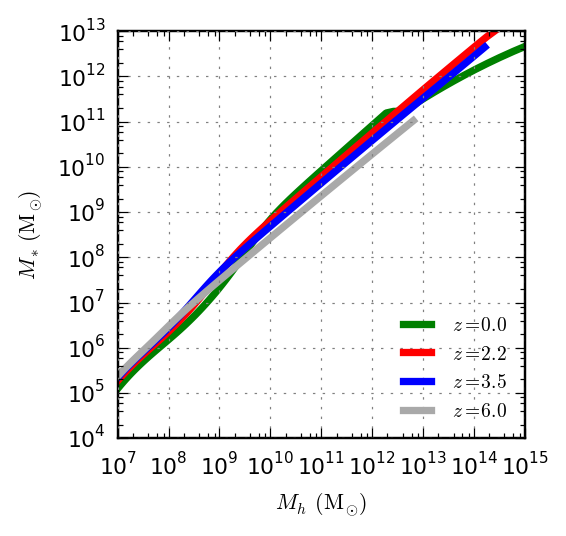

In [18]:
import numpy as np
import code.galaxy_model as gm
from colossus.cosmology import cosmology
from colossus.halo.concentration import concentration
from colossus.halo.mass_defs import changeMassDefinition

# define a vector of cosmological parameters:    
my_cosmo = {'flat': True, 'H0': 70.0, 'Om0': 0.27, 'Ob0': 0.045714, 'sigma8': 0.82, 'ns': 0.96}
# set my_cosmo to be the current cosmology
cosmo = cosmology.setCosmology('my_cosmo', my_cosmo)  
from scipy.integrate import odeint

# inherit class for this homework from the base model_galaxy class
# add the required functions to it
class gmodel_hw4(gm.model_galaxy):
    def __init__(self, *args, **kwargs):
        # only one model based on total gas density for starters, a better model is to be implemented
        super(gmodel_hw4, self).__init__(*args, **kwargs)
        return

    def Mhot(self, z):
        mnl = self.cosmo.nonLinearMass(z)
        mhot = 1.e12 * self.cosmo.h * np.maximum(2., 1.e12/(3.*mnl/self.cosmo.h))
        return mhot
       
    def UV_cutoff(self, z):
        """
        approximation to the cutoff mass in Fig 3 of Okamoto, Gao & Theuns 2008
        the output is mass in /h Msun. 
        """
        dummy = np.zeros_like(z)
        dummy[z>9] = 1.e6
        dummy[z<=9] = 6.e9*np.exp(-0.63*z[z<9]) # expression from Nick
        return  1.0/(1.0+(2.**(2./3.)-1.)*(dummy/self.Mh)**2)**(1.5)

    def Mg_in(self, t):
        dummy = self.fbuni*self.fg_in(t)*self.eps_in(t)*self.dMhdt(self.Mh,t)
        return dummy
    
    def fg_in(self,t):
        zd = self.cosmo.age(t, inverse=True)
        # here I implement soft suppression of baryon fraction, as seen in simulation (eq 2.2 in the notes)
        # results are qualitatively the same, but this function makes suppression a "softer" as a function of M
        return self.UV_cutoff(zd)
    
    def eps_in(self, t):
        zd = self.cosmo.age(t, inverse=True)
        epsin = 1.0
        if self.Mh >= self.Mhot(zd):
            epsin = 0.0
        return epsin
    def r12(self, t):
        jm = 1.
        fR = 1.
        lmbda = 0.045
        zd = self.cosmo.age(t, inverse=True)
        c = concentration(self.Mh, 'vir', zd, model='diemer15')
        fc = 0.5*c*(1.-1./(1.+c)**2-2.*np.log(1.+c)/(1.+c))/(c/(1.+c)-np.log(1.+c))**2
        M200c, R200c, c200c = changeMassDefinition(self.Mh*self.cosmo.h, c, zd, 'vir', '200c')
        return 1.187*jm*fR*lmbda*R200c/np.sqrt(fc)
    
    def Rd(self, r12):
        return r12/1.678
    
    def fH2(self, MZ, Mg,t):
        r12 = self.r12(t)
        Rd = self.Rd(r12)
        Z0 = (MZ/Mg)/0.02
        Sigma0 = Mg/(2*np.pi*Rd**2)
        chi = 3.1*(1+Z0**0.365)/4.1
        tauc = 320*5*Z0*Sigma0
        s = np.log(1+0.6*chi+0.01*chi**2)/(0.6*tauc)
        if s < 2:
            return (1-0.75*s/(1+0.25*s))
        else:
            return 0.0
        
    def SFRgaslinear(self, t):
        tauH2 = 1. #Gyr
        f_H2 = self.fH2(self.MZ, self.Mg, t)
        MH2 = self.Mg*f_H2
        return MH2/tauH2
    
def test_galaxy_evolution(Minit, sfrmodel, cosmo, verbose):
    zg = np.linspace(20., 0., 40) # grid of redshifts
    t_output = cosmo.age(zg) # and corresponding times

    # instantiate a galaxy model at t=tinit assuming a given star fromation model and cosmology
    g = gmodel_hw4(t = t_output[0], Mh = Minit, Mg = None, Ms = None, MZ = None, 
                     sfrmodel = sfrmodel, cosmo = cosmo, verbose = verbose)
    
    # array of quantities to evolve with ODE solver
    y0 = np.array([g.Mh, g.Mg, g.Ms, g.MZ])
    # evolve y0 in time
    Mout = odeint(g.evolve, y0, t_output, rtol = 1.e-7, mxstep = 4000)
    
    # let's split the output into arrays with intuitive names
    Mhout = np.clip(Mout[:,0],0.0,1.e100)
    Mgout = np.clip(Mout[:,1],0.0,1.e100)
    Msout = np.clip(Mout[:,2],0.0,1.e100)
    MZout = np.clip(Mout[:,3],0.0,1.e100)

    return zg, t_output, Mhout, Mgout, Msout, MZout
sfrmodel = "gaslinear"  
# let's take a look at how a halo that has MW-like halo mass at z=0 evolves
# the class method test_galaxy_evolution does some basic run of the model and plots results, so let's setup 
# matplotlib parameters for plotting
from code.plot_utils import plot_pretty
%matplotlib inline
from matplotlib import pylab as plt

zg, t_output, Mhout, Mgout, Msout, MZout = test_galaxy_evolution(Minit=2.1e8, sfrmodel=sfrmodel, cosmo=cosmo, 
                                                                 verbose=False)

#
# plot
#
tu = cosmo.age(0.0) # the age of the Universe
plt.rc("savefig",dpi=175)
plt.rc('text', usetex=False)
plt.rc('font',size=9)
plt.rc('xtick.major',pad=5); plt.rc('xtick.minor',pad=5)
plt.rc('ytick.major',pad=5); plt.rc('ytick.minor',pad=5)

from scipy.interpolate import interp2d

# initial metallicity
Z_IGM = 2.e-5

# grid of redshifts and halo masses
Nz = 41; Nm = 100
zg = np.linspace(30., 0., Nz)
lzg1 = np.log10(1.0+zg)
t_output = cosmo.age(zg)
    
lMh = np.linspace(5.0, 8., Nm)
Mh  = np.power(10, lMh)

# arrays to hold evolutionary grids of halo mass, gas mass, stellar mass and metal mass
Mhout = np.zeros((Nm,Nz)); Mgout = np.zeros((Nm,Nz))
Msout = np.zeros((Nm,Nz)); MZout = np.zeros((Nm,Nz))
#evolve a grid of halo masses
for j, Mhd in enumerate(Mh):
    if not j%5:
        print "evolving halo of log10(Mh)=%2.2f ..."%(lMh[j])
    # instantiate a model galaxy with a given halo mass at the initial time
    g = gmodel_hw4(t = t_output[0], Mh = Mhd, Mg = None, Ms = None, MZ = None, Z_IGM = Z_IGM, sfrmodel = sfrmodel, cosmo = cosmo)
    # initial values of masses
    y0 = np.array([g.Mh, g.Mg, g.Ms, g.MZ])
    # solve the system of ODEs
    Mout = odeint(g.evolve, y0, t_output, rtol = 1.e-5, mxstep = 4000)
    Mout = Mout/g.cosmo.h
    # split Mout into arrays for specific masses with more intuitive names for convenience
    Mhout[j,:] = Mout[:,0]; Mgout[j,:] = Mout[:,1]
    Msout[j,:] = Mout[:,2]; MZout[j,:] = Mout[:,3]
# 
# prepare 2D splines for interpolation
#
Mmin = 1.e-10 # prevent zeros in case no SF occurred
lMhi = interp2d(lzg1, lMh, np.log10(np.maximum(Mmin,Mhout)), bounds_error=True, kind='cubic')
lMgi = interp2d(lzg1, lMh, np.log10(np.maximum(Mmin,Mgout)), bounds_error=True, kind='cubic')
lMsi = interp2d(lzg1, lMh, np.log10(np.maximum(Mmin,Msout)), bounds_error=True, kind='cubic')
lMZi = interp2d(lzg1, lMh, np.log10(np.maximum(Mmin,MZout)), bounds_error=True, kind='cubic')

r12array = np.zeros((len(t_output)))
Rdarray = np.zeros((len(t_output)))
for i in range(len(t_output)):
    g = gmodel_hw4(t = t_output[i], Mh = Mhout[50,20], Mg=Mgout[50,20], Ms=Msout[50,20], MZ =MZout[50,20], Z_IGM = Z_IGM, sfrmodel = sfrmodel, cosmo = cosmo)
    r12array[i] = g.r12(t_output[i])
    Rdarray[i] = g.Rd(r12array[i])
#
# plot
#

fig = plt.figure(figsize=(3, 3))
#plot_pretty()
plt.xlabel(r'$M_h\ \rm (M_\odot)$')
plt.ylabel(r'$M_{*}\ \rm (M_\odot)$')
plt.xlim(1.e7,1.e15); plt.ylim(1.e4,1.e13)
plt.xscale('log'); plt.yscale('log')
        
z_plot = np.array([0., 2.2, 3.5, 6.0])
# colors a la Feldmann for easier comparison
zcolors = ['green', 'red', 'blue', 'darkgray']
for i, zplot in enumerate(z_plot):
    Mhz = 10.**lMhi(np.log10(1.0+zplot),lMh)
    Msz = 10.**lMsi(np.log10(1.0+zplot),lMh)
    plt.plot(Mhz, Msz, c=zcolors[i], lw=3.0, label=r'$z=%1.1f$'%zplot)

#zdata=0.
#plt.plot(mh,10.**mhms,c='darkorange',linewidth=2.0, label=r'$\mathrm{AM} \ z=%.1f$'%zdata)

plt.legend(frameon=False,loc='lower right', fontsize=8)
plt.grid(c='gray')
#plt.savefig('fig/mhms_nofbk.pdf',bbox_inches='tight')
plt.show()

#z_plot = np.array([0., 2.2, 3.5, 6.0])
## colors a la Feldmann for easier comparison
#zcolors = ['green', 'red', 'blue', 'darkgray']
#for i, zplot in enumerate(z_plot):
#    Mhz = 10.**lMhi(np.log10(1.0+zplot),lMh)
#    Msz = 10.**lMsi(np.log10(1.0+zplot),lMh)
#    plt.plot(Mhz, Msz/Mhz, c=zcolors[i], lw=3.0, label=r'$z=%1.1f$'%zplot)

##zdata=0.
##plt.plot(mh,10.**mhms,c='darkorange',linewidth=2.0, label=r'$\mathrm{AM} \ z=%.1f$'%zdata)

#plt.legend(frameon=False,loc='lower right', fontsize=8)
#plt.grid(c='gray')
#plt.savefig('fig/mhms_nofbk.pdf',bbox_inches='tight')
#plt.show()

Yes there are some slight differences with the results from homework 4. In particular some curves seem to have a steeper slope, such as $z=2.2$ curve and the $z=6$ curve seems to have shifted upwards slightly.
In the paper by Krumholz and Dekel, they state that $f_{H2}$ is "determined by the balance between grain photoelectric heating and UV photodissociation on one hand, and collisionally-excited metal line cooling and H2 formation on dust grains on the other hand". Thus, one would expect $f_{H2}$ to depend mainly on surface density and metallicity of the galactic disk. In particular, regions with low surface density are primarily atomic, and those with high surface density are primarily molecular.

Question #4

evolving halo of log10(Mh)=5.00 ...
evolving halo of log10(Mh)=5.15 ...
evolving halo of log10(Mh)=5.30 ...
evolving halo of log10(Mh)=5.45 ...
evolving halo of log10(Mh)=5.61 ...
evolving halo of log10(Mh)=5.76 ...
evolving halo of log10(Mh)=5.91 ...
evolving halo of log10(Mh)=6.06 ...
evolving halo of log10(Mh)=6.21 ...
evolving halo of log10(Mh)=6.36 ...
evolving halo of log10(Mh)=6.52 ...
evolving halo of log10(Mh)=6.67 ...
evolving halo of log10(Mh)=6.82 ...
evolving halo of log10(Mh)=6.97 ...
evolving halo of log10(Mh)=7.12 ...
evolving halo of log10(Mh)=7.27 ...
evolving halo of log10(Mh)=7.42 ...
evolving halo of log10(Mh)=7.58 ...
evolving halo of log10(Mh)=7.73 ...
evolving halo of log10(Mh)=7.88 ...


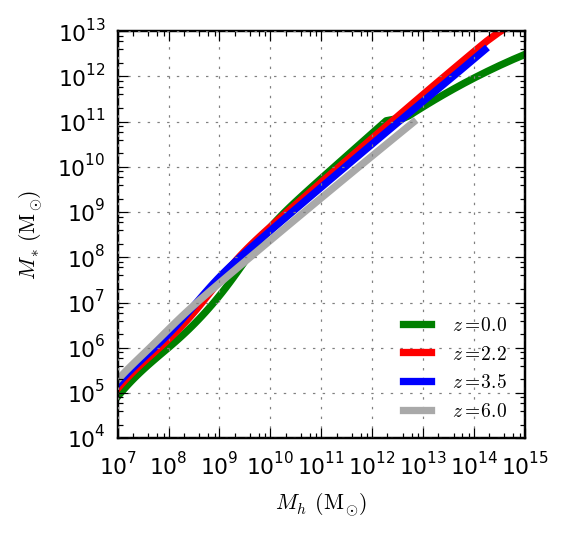

In [19]:
import numpy as np
import code.galaxy_model as gm
from colossus.cosmology import cosmology
from colossus.halo.concentration import concentration
from colossus.halo.mass_defs import changeMassDefinition

# define a vector of cosmological parameters:    
my_cosmo = {'flat': True, 'H0': 70.0, 'Om0': 0.27, 'Ob0': 0.045714, 'sigma8': 0.82, 'ns': 0.96}
# set my_cosmo to be the current cosmology
cosmo = cosmology.setCosmology('my_cosmo', my_cosmo)  
from scipy.integrate import odeint

# inherit class for this homework from the base model_galaxy class
# add the required functions to it
class gmodel_hw4(gm.model_galaxy):
    def __init__(self, *args, **kwargs):
        # only one model based on total gas density for starters, a better model is to be implemented
        super(gmodel_hw4, self).__init__(*args, **kwargs)
        return

    def Mhot(self, z):
        mnl = self.cosmo.nonLinearMass(z)
        mhot = 1.e12 * self.cosmo.h * np.maximum(2., 1.e12/(3.*mnl/self.cosmo.h))
        return mhot
       
    def UV_cutoff(self, z):
        """
        approximation to the cutoff mass in Fig 3 of Okamoto, Gao & Theuns 2008
        the output is mass in /h Msun. 
        """
        dummy = np.zeros_like(z)
        dummy[z>9] = 1.e6
        dummy[z<=9] = 6.e9*np.exp(-0.63*z[z<9]) # expression from Nick
        return  1.0/(1.0+(2.**(2./3.)-1.)*(dummy/self.Mh)**2)**(1.5)

    def Mg_in(self, t):
        dummy = self.fbuni*self.fg_in(t)*self.eps_in(t)*self.dMhdt(self.Mh,t)
        return dummy
    
    def fg_in(self,t):
        zd = self.cosmo.age(t, inverse=True)
        # here I implement soft suppression of baryon fraction, as seen in simulation (eq 2.2 in the notes)
        # results are qualitatively the same, but this function makes suppression a "softer" as a function of M
        return self.UV_cutoff(zd)
    
    def eps_in(self, t):
        zd = self.cosmo.age(t, inverse=True)
        epsin = 1.0
        if self.Mh >= self.Mhot(zd):
            epsin = 0.0
        return epsin
    def r12(self, t):
        jm = 1.
        fR = 1.
        lmbda = 0.045
        zd = self.cosmo.age(t, inverse=True)
        c = concentration(self.Mh, 'vir', zd, model='diemer15')
        fc = 0.5*c*(1.-1./(1.+c)**2-2.*np.log(1.+c)/(1.+c))/(c/(1.+c)-np.log(1.+c))**2
        M200c, R200c, c200c = changeMassDefinition(self.Mh*self.cosmo.h, c, zd, 'vir', '200c')
        return 1.187*jm*fR*lmbda*R200c/np.sqrt(fc)
    
    def Rd(self, r12):
        return r12/1.678
    
    def fH2(self, MZ, Mg,t):
        r12 = self.r12(t)
        Rd = self.Rd(r12)
        Z0 = (MZ/Mg)/0.02
        Sigma0 = Mg/(2*np.pi*Rd**2)
        chi = 3.1*(1+Z0**0.365)/4.1
        tauc = 320*5*Z0*Sigma0
        s = np.log(1+0.6*chi+0.01*chi**2)/(0.6*tauc)
        if s < 2:
            return (1-0.75*s/(1+0.25*s))
        else:
            return 0.0
        
    def SFRgaslinear(self, t):
        tauH2 = 1. #Gyr
        f_H2 = self.fH2(self.MZ, self.Mg, t)
        MH2 = self.Mg*f_H2
        return MH2/tauH2
    
    def dMgdt(self, Mcurrent, t):
        dummy = self.Mgin - (self.Rloss1 + self.epsout)*self.sfr - self.epsout*self.dMsdt(Mcurrent, t)
        return dummy
    
def test_galaxy_evolution(Minit, sfrmodel, cosmo, verbose):
    zg = np.linspace(20., 0., 40) # grid of redshifts
    t_output = cosmo.age(zg) # and corresponding times

    # instantiate a galaxy model at t=tinit assuming a given star fromation model and cosmology
    g = gmodel_hw4(t = t_output[0], Mh = Minit, Mg = None, Ms = None, MZ = None, 
                     sfrmodel = sfrmodel, cosmo = cosmo, verbose = verbose)
    
    # array of quantities to evolve with ODE solver
    y0 = np.array([g.Mh, g.Mg, g.Ms, g.MZ])
    # evolve y0 in time
    Mout = odeint(g.evolve, y0, t_output, rtol = 1.e-7, mxstep = 4000)
    
    # let's split the output into arrays with intuitive names
    Mhout = np.clip(Mout[:,0],0.0,1.e100)
    Mgout = np.clip(Mout[:,1],0.0,1.e100)
    Msout = np.clip(Mout[:,2],0.0,1.e100)
    MZout = np.clip(Mout[:,3],0.0,1.e100)

    return zg, t_output, Mhout, Mgout, Msout, MZout
sfrmodel = "gaslinear"  
# let's take a look at how a halo that has MW-like halo mass at z=0 evolves
# the class method test_galaxy_evolution does some basic run of the model and plots results, so let's setup 
# matplotlib parameters for plotting
from code.plot_utils import plot_pretty
%matplotlib inline
from matplotlib import pylab as plt

zg, t_output, Mhout, Mgout, Msout, MZout = test_galaxy_evolution(Minit=2.1e8, sfrmodel=sfrmodel, cosmo=cosmo, 
                                                                 verbose=False)

#
# plot
#
tu = cosmo.age(0.0) # the age of the Universe
plt.rc("savefig",dpi=175)
plt.rc('text', usetex=False)
plt.rc('font',size=9)
plt.rc('xtick.major',pad=5); plt.rc('xtick.minor',pad=5)
plt.rc('ytick.major',pad=5); plt.rc('ytick.minor',pad=5)

from scipy.interpolate import interp2d

# initial metallicity
Z_IGM = 2.e-5

# grid of redshifts and halo masses
Nz = 41; Nm = 100
zg = np.linspace(30., 0., Nz)
lzg1 = np.log10(1.0+zg)
t_output = cosmo.age(zg)
    
lMh = np.linspace(5.0, 8., Nm)
Mh  = np.power(10, lMh)

# arrays to hold evolutionary grids of halo mass, gas mass, stellar mass and metal mass
Mhout = np.zeros((Nm,Nz)); Mgout = np.zeros((Nm,Nz))
Msout = np.zeros((Nm,Nz)); MZout = np.zeros((Nm,Nz))
#evolve a grid of halo masses
for j, Mhd in enumerate(Mh):
    if not j%5:
        print "evolving halo of log10(Mh)=%2.2f ..."%(lMh[j])
    # instantiate a model galaxy with a given halo mass at the initial time
    g = gmodel_hw4(t = t_output[0], Mh = Mhd, Mg = None, Ms = None, MZ = None, Z_IGM = Z_IGM, sfrmodel = sfrmodel, cosmo = cosmo)
    # initial values of masses
    y0 = np.array([g.Mh, g.Mg, g.Ms, g.MZ])
    # solve the system of ODEs
    Mout = odeint(g.evolve, y0, t_output, rtol = 1.e-5, mxstep = 4000)
    Mout = Mout/g.cosmo.h
    # split Mout into arrays for specific masses with more intuitive names for convenience
    Mhout[j,:] = Mout[:,0]; Mgout[j,:] = Mout[:,1]
    Msout[j,:] = Mout[:,2]; MZout[j,:] = Mout[:,3]
# 
# prepare 2D splines for interpolation
#
Mmin = 1.e-10 # prevent zeros in case no SF occurred
lMhi = interp2d(lzg1, lMh, np.log10(np.maximum(Mmin,Mhout)), bounds_error=True, kind='cubic')
lMgi = interp2d(lzg1, lMh, np.log10(np.maximum(Mmin,Mgout)), bounds_error=True, kind='cubic')
lMsi = interp2d(lzg1, lMh, np.log10(np.maximum(Mmin,Msout)), bounds_error=True, kind='cubic')
lMZi = interp2d(lzg1, lMh, np.log10(np.maximum(Mmin,MZout)), bounds_error=True, kind='cubic')

r12array = np.zeros((len(t_output)))
Rdarray = np.zeros((len(t_output)))
for i in range(len(t_output)):
    g = gmodel_hw4(t = t_output[i], Mh = Mhout[50,20], Mg=Mgout[50,20], Ms=Msout[50,20], MZ =MZout[50,20], Z_IGM = Z_IGM, sfrmodel = sfrmodel, cosmo = cosmo)
    r12array[i] = g.r12(t_output[i])
    Rdarray[i] = g.Rd(r12array[i])
#
# plot
#

fig = plt.figure(figsize=(3, 3))
#plot_pretty()
plt.xlabel(r'$M_h\ \rm (M_\odot)$')
plt.ylabel(r'$M_{*}\ \rm (M_\odot)$')
plt.xlim(1.e7,1.e15); plt.ylim(1.e4,1.e13)
plt.xscale('log'); plt.yscale('log')
        
z_plot = np.array([0., 2.2, 3.5, 6.0])
# colors a la Feldmann for easier comparison
zcolors = ['green', 'red', 'blue', 'darkgray']
for i, zplot in enumerate(z_plot):
    Mhz = 10.**lMhi(np.log10(1.0+zplot),lMh)
    Msz = 10.**lMsi(np.log10(1.0+zplot),lMh)
    plt.plot(Mhz, Msz, c=zcolors[i], lw=3.0, label=r'$z=%1.1f$'%zplot)

#zdata=0.
#plt.plot(mh,10.**mhms,c='darkorange',linewidth=2.0, label=r'$\mathrm{AM} \ z=%.1f$'%zdata)

plt.legend(frameon=False,loc='lower right', fontsize=8)
plt.grid(c='gray')
#plt.savefig('fig/mhms_nofbk.pdf',bbox_inches='tight')
plt.show()



There is little effect of the outflow incorporated this way. The additional $\frac{dMg}{dt}$ expelled is quite small compared to the original value (less than a tenth, when I checked by printing the values). 

4b)

evolving halo of log10(Mh)=5.00 ...
evolving halo of log10(Mh)=5.15 ...
evolving halo of log10(Mh)=5.30 ...
evolving halo of log10(Mh)=5.45 ...
evolving halo of log10(Mh)=5.61 ...
evolving halo of log10(Mh)=5.76 ...
evolving halo of log10(Mh)=5.91 ...
evolving halo of log10(Mh)=6.06 ...
evolving halo of log10(Mh)=6.21 ...
evolving halo of log10(Mh)=6.36 ...
evolving halo of log10(Mh)=6.52 ...
evolving halo of log10(Mh)=6.67 ...
evolving halo of log10(Mh)=6.82 ...
evolving halo of log10(Mh)=6.97 ...
evolving halo of log10(Mh)=7.12 ...
evolving halo of log10(Mh)=7.27 ...
evolving halo of log10(Mh)=7.42 ...
evolving halo of log10(Mh)=7.58 ...
evolving halo of log10(Mh)=7.73 ...
evolving halo of log10(Mh)=7.88 ...


/home/tangq/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:70: RuntimeWarning: invalid value encountered in double_scalars


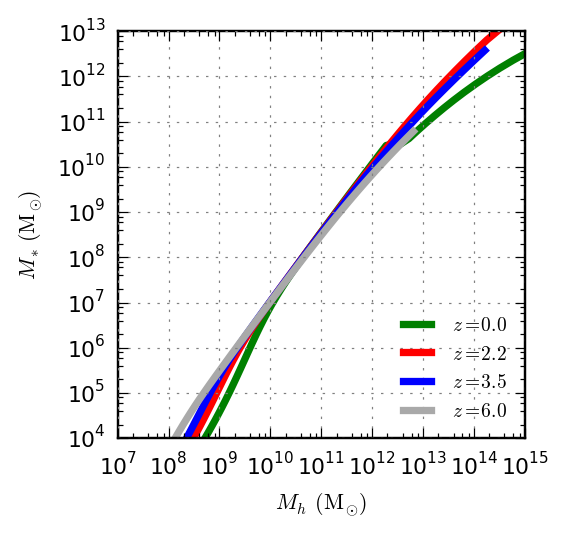

In [15]:
import numpy as np
import code.galaxy_model as gm
from colossus.cosmology import cosmology
from colossus.halo.concentration import concentration
from colossus.halo.mass_defs import changeMassDefinition

# define a vector of cosmological parameters:    
my_cosmo = {'flat': True, 'H0': 70.0, 'Om0': 0.27, 'Ob0': 0.045714, 'sigma8': 0.82, 'ns': 0.96}
# set my_cosmo to be the current cosmology
cosmo = cosmology.setCosmology('my_cosmo', my_cosmo)  
from scipy.integrate import odeint

# inherit class for this homework from the base model_galaxy class
# add the required functions to it
class gmodel_hw44(gm.model_galaxy):
    def __init__(self, *args, **kwargs):
        # only one model based on total gas density for starters, a better model is to be implemented
        super(gmodel_hw44, self).__init__(*args, **kwargs)
        return

    def Mhot(self, z):
        mnl = self.cosmo.nonLinearMass(z)
        mhot = 1.e12 * self.cosmo.h * np.maximum(2., 1.e12/(3.*mnl/self.cosmo.h))
        return mhot
       
    def UV_cutoff(self, z):
        """
        approximation to the cutoff mass in Fig 3 of Okamoto, Gao & Theuns 2008
        the output is mass in /h Msun. 
        """
        dummy = np.zeros_like(z)
        dummy[z>9] = 1.e6
        dummy[z<=9] = 6.e9*np.exp(-0.63*z[z<9]) # expression from Nick
        return  1.0/(1.0+(2.**(2./3.)-1.)*(dummy/self.Mh)**2)**(1.5)

    def Mg_in(self, t):
        dummy = self.fbuni*self.fg_in(t)*self.eps_in(t)*self.dMhdt(self.Mh,t)
        return dummy
    
    def fg_in(self,t):
        zd = self.cosmo.age(t, inverse=True)
        # here I implement soft suppression of baryon fraction, as seen in simulation (eq 2.2 in the notes)
        # results are qualitatively the same, but this function makes suppression a "softer" as a function of M
        return self.UV_cutoff(zd)
    
    def eps_in(self, t):
        zd = self.cosmo.age(t, inverse=True)
        epsin = 1.0
        if self.Mh >= self.Mhot(zd):
            epsin = 0.0
        return epsin
    def r12(self, t):
        jm = 1.
        fR = 1.
        lmbda = 0.045
        zd = self.cosmo.age(t, inverse=True)
        c = concentration(self.Mh, 'vir', zd, model='diemer15')
        fc = 0.5*c*(1.-1./(1.+c)**2-2.*np.log(1.+c)/(1.+c))/(c/(1.+c)-np.log(1.+c))**2
        M200c, R200c, c200c = changeMassDefinition(self.Mh*self.cosmo.h, c, zd, 'vir', '200c')
        return 1.187*jm*fR*lmbda*R200c/np.sqrt(fc)
    
    def Rd(self, r12):
        return r12/1.678
    
    def fH2(self, MZ, Mg,t):
        r12 = self.r12(t)
        Rd = self.Rd(r12)
        Z0 = (MZ/Mg)/0.02
        Sigma0 = Mg/(2*np.pi*Rd**2)
        chi = 3.1*(1+Z0**0.365)/4.1
        tauc = 320*5*Z0*Sigma0
        s = np.log(1+0.6*chi+0.01*chi**2)/(0.6*tauc)
        if s < 2:
            return (1-0.75*s/(1+0.25*s))
        else:
            return 0.0
        
    def SFRgaslinear(self, t):
        tauH2 = 1. #Gyr
        f_H2 = self.fH2(self.MZ, self.Mg, t)
        MH2 = self.Mg*f_H2
        return MH2/tauH2
    
    def eps_out(self):
        if self.Ms == 0.:
            mass = 1.e-15
        else:
            mass = self.Ms
        epsout = 3.6*(self.cosmo.h*mass/(1.e10))**(-0.35)
        return epsout
    
    def dMgdt(self, Mcurrent, t):
        dummy = self.Mgin - (self.Rloss1 + self.epsout)*self.sfr - self.epsout*self.dMsdt(Mcurrent, t)
        return dummy

    
def test_galaxy_evolution(Minit, sfrmodel, cosmo, verbose):
    zg = np.linspace(20., 0., 40) # grid of redshifts
    t_output = cosmo.age(zg) # and corresponding times

    # instantiate a galaxy model at t=tinit assuming a given star fromation model and cosmology
    g = gmodel_hw44(t = t_output[0], Mh = Minit, Mg = None, Ms = None, MZ = None, 
                     sfrmodel = sfrmodel, cosmo = cosmo, verbose = verbose)
    
    # array of quantities to evolve with ODE solver
    y0 = np.array([g.Mh, g.Mg, g.Ms, g.MZ])
    # evolve y0 in time
    Mout = odeint(g.evolve, y0, t_output, rtol = 1.e-7, mxstep = 4000)
    
    # let's split the output into arrays with intuitive names
    Mhout = np.clip(Mout[:,0],0.0,1.e100)
    Mgout = np.clip(Mout[:,1],0.0,1.e100)
    Msout = np.clip(Mout[:,2],0.0,1.e100)
    MZout = np.clip(Mout[:,3],0.0,1.e100)

    return zg, t_output, Mhout, Mgout, Msout, MZout
sfrmodel = "gaslinear"  
# let's take a look at how a halo that has MW-like halo mass at z=0 evolves
# the class method test_galaxy_evolution does some basic run of the model and plots results, so let's setup 
# matplotlib parameters for plotting
from code.plot_utils import plot_pretty
%matplotlib inline
from matplotlib import pylab as plt

zg, t_output, Mhout, Mgout, Msout, MZout = test_galaxy_evolution(Minit=2.1e8, sfrmodel=sfrmodel, cosmo=cosmo, 
                                                                 verbose=False)

#
# plot
#
tu = cosmo.age(0.0) # the age of the Universe
plt.rc("savefig",dpi=175)
plt.rc('text', usetex=False)
plt.rc('font',size=9)
plt.rc('xtick.major',pad=5); plt.rc('xtick.minor',pad=5)
plt.rc('ytick.major',pad=5); plt.rc('ytick.minor',pad=5)

from scipy.interpolate import interp2d

# initial metallicity
Z_IGM = 2.e-5

# grid of redshifts and halo masses
Nz = 41; Nm = 100
zg = np.linspace(30., 0., Nz)
lzg1 = np.log10(1.0+zg)
t_output = cosmo.age(zg)
    
lMh = np.linspace(5.0, 8., Nm)
Mh  = np.power(10, lMh)

# arrays to hold evolutionary grids of halo mass, gas mass, stellar mass and metal mass
Mhout = np.zeros((Nm,Nz)); Mgout = np.zeros((Nm,Nz))
Msout = np.zeros((Nm,Nz)); MZout = np.zeros((Nm,Nz))
#evolve a grid of halo masses
for j, Mhd in enumerate(Mh):
    if not j%5:
        print "evolving halo of log10(Mh)=%2.2f ..."%(lMh[j])
    # instantiate a model galaxy with a given halo mass at the initial time
    g = gmodel_hw44(t = t_output[0], Mh = Mhd, Mg = None, Ms = None, MZ = None, Z_IGM = Z_IGM, sfrmodel = sfrmodel, cosmo = cosmo)
    # initial values of masses
    y0 = np.array([g.Mh, g.Mg, g.Ms, g.MZ])
    # solve the system of ODEs
    Mout = odeint(g.evolve, y0, t_output, rtol = 1.e-5, mxstep = 4000)
    Mout = Mout/g.cosmo.h
    # split Mout into arrays for specific masses with more intuitive names for convenience
    Mhout[j,:] = Mout[:,0]; Mgout[j,:] = Mout[:,1]
    Msout[j,:] = Mout[:,2]; MZout[j,:] = Mout[:,3]
# 
# prepare 2D splines for interpolation
#
Mmin = 1.e-10 # prevent zeros in case no SF occurred
lMhi = interp2d(lzg1, lMh, np.log10(np.maximum(Mmin,Mhout)), bounds_error=True, kind='cubic')
lMgi = interp2d(lzg1, lMh, np.log10(np.maximum(Mmin,Mgout)), bounds_error=True, kind='cubic')
lMsi = interp2d(lzg1, lMh, np.log10(np.maximum(Mmin,Msout)), bounds_error=True, kind='cubic')
lMZi = interp2d(lzg1, lMh, np.log10(np.maximum(Mmin,MZout)), bounds_error=True, kind='cubic')

r12array = np.zeros((len(t_output)))
Rdarray = np.zeros((len(t_output)))
for i in range(len(t_output)):
    g = gmodel_hw4(t = t_output[i], Mh = Mhout[50,20], Mg=Mgout[50,20], Ms=Msout[50,20], MZ =MZout[50,20], Z_IGM = Z_IGM, sfrmodel = sfrmodel, cosmo = cosmo)
    r12array[i] = g.r12(t_output[i])
    Rdarray[i] = g.Rd(r12array[i])
#
# plot
#

fig = plt.figure(figsize=(3, 3))
#plot_pretty()
plt.xlabel(r'$M_h\ \rm (M_\odot)$')
plt.ylabel(r'$M_{*}\ \rm (M_\odot)$')
plt.xlim(1.e7,1.e15); plt.ylim(1.e4,1.e13)
plt.xscale('log'); plt.yscale('log')
        
z_plot = np.array([0., 2.2, 3.5, 6.0])
# colors a la Feldmann for easier comparison
zcolors = ['green', 'red', 'blue', 'darkgray']
for i, zplot in enumerate(z_plot):
    Mhz = 10.**lMhi(np.log10(1.0+zplot),lMh)
    Msz = 10.**lMsi(np.log10(1.0+zplot),lMh)
    plt.plot(Mhz, Msz, c=zcolors[i], lw=3.0, label=r'$z=%1.1f$'%zplot)

#zdata=0.
#plt.plot(mh,10.**mhms,c='darkorange',linewidth=2.0, label=r'$\mathrm{AM} \ z=%.1f$'%zdata)

plt.legend(frameon=False,loc='lower right', fontsize=8)
plt.grid(c='gray')
#plt.savefig('fig/mhms_nofbk.pdf',bbox_inches='tight')
plt.show()

We see that incorporating wind outflows in this manner, dramatically decreases the stellar mass at low halo mass. When we added the $M_*$ dependency for $\epsilon_{out}$, it caused the relation to steepen at very low and very high stellar mass ranges.